In [381]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
from torch import cuda
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

In [414]:
df_men_train =pd.read_csv( r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\model\excel_sheets\git_image_paths_val_men.csv")
df_men_train["Images"] = df_men_train["Images"].str.replace("C:/Users/busse/Bachelorarbeit/CICD-Pipeline-Gender-Recognition/", " ")
df_men_train.to_csv(r"C:\Users\busse\Bachelorarbeit\CICD-Pipeline-Gender-Recognition\model\excel_sheets\git_image_paths_val_men.csv")


In [415]:


epochs = 5
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Apply the transformation to your dataset
train_dataset = datasets.ImageFolder(root='data/train',transform=transform)
test_dataset = datasets.ImageFolder(root= 'data/val',transform=transform)
df_men_train = pd.read_csv("model/excel_sheets/git_image_paths_men.csv")
df_women_train = pd.read_csv("model/excel_sheets/git_image_paths_women.csv")
df_women_test = pd.read_csv("model/excel_sheets/git_image_paths_val_women.csv")
df_men_test = pd.read_csv("model/excel_sheets/git_image_paths_val_men.csv")
merged_df_train = pd.concat([df_men_train, df_women_train], ignore_index=True)
merged_df_test = pd.concat([df_men_test, df_women_test], ignore_index=True)
merged_df_test.to_csv("git_merged_df_test.csv")
merged_df_train.to_csv("git_merged_df_train.csv")

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'data/train'

In [383]:

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


train_data = CustomImageDataset(annotations_file='model/git_merged_df_train.csv',img_dir='data/train')
test_data =  CustomImageDataset(annotations_file='model/git_merged_df_test.csv',img_dir='data/val')

In [399]:


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 218, 178])
Labels batch shape: torch.Size([64])


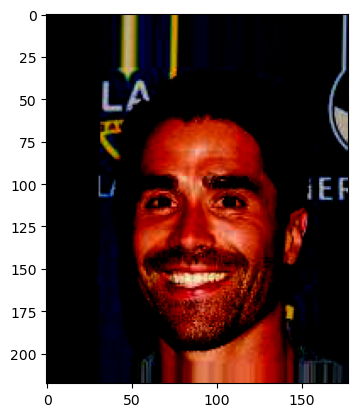

In [400]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = train_features[0].permute(1, 2, 0)
plt.imshow(img, cmap="gray")

In [403]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print("Using {} device".format(device))

Using cpu device


In [404]:


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(4, 4)  # 4x4 max pooling
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2,2)  # 6 input channels, 16 output channels, 5x5 kernel
        self.fc1 = nn.Linear(33456 , 120)  # 53*53 from the dimension of the image after convolutions
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # 2 output classes
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the output of the conv layers
        x = F.relu(self.fc1(x))  # Apply ReLU to the output of the first fully connected layer
        x = F.relu(self.fc2(x))  # Apply ReLU to the output of the second fully connected layer
        x = self.fc3(x)  # No activation function is applied to the output of the last layer
        return x

In [405]:
import torch.optim as optim
from tqdm import tqdm

# Instantiate the model, loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Assume `val_dataloader` is your DataLoader for the validation set
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_dataloader), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  
         

        # Trainingsverlauf ausgeben
        running_loss += loss.item()

        #Alle 10 Batches wird der Loss ausgegeben
        if i % 10 == 9:    
            # Berechnung der Accuracy
            correct = 0
            total = 0
            with torch.no_grad():
                for val_data in test_dataloader:
                    val_images, val_labels = val_data
                    val_outputs = model(val_images)
                    _, predicted = torch.max(val_outputs.data, 1)
                    total += val_labels.size(0)
                    correct += (predicted == val_labels).sum().item()
            val_accuracy = correct / total

            print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 10}, Validation Accuracy: {val_accuracy * 100}%')
            running_loss = 0.0

print('Finished Training')

 16%|█▌        | 10/63 [00:10<02:22,  2.68s/it]

Epoch: 1, Batch: 10, Loss: 0.693843811750412, Validation Accuracy: 52.05%


 32%|███▏      | 20/63 [00:20<01:48,  2.51s/it]

Epoch: 1, Batch: 20, Loss: 0.6893204629421235, Validation Accuracy: 50.55%


 48%|████▊     | 30/63 [00:32<01:33,  2.83s/it]

Epoch: 1, Batch: 30, Loss: 0.6873774588108063, Validation Accuracy: 58.050000000000004%


 63%|██████▎   | 40/63 [00:42<00:57,  2.50s/it]

Epoch: 1, Batch: 40, Loss: 0.6825783967971801, Validation Accuracy: 67.95%


 79%|███████▉  | 50/63 [00:53<00:34,  2.66s/it]

Epoch: 1, Batch: 50, Loss: 0.6803463160991668, Validation Accuracy: 68.85%


 95%|█████████▌| 60/63 [01:02<00:07,  2.37s/it]

Epoch: 1, Batch: 60, Loss: 0.6694580018520355, Validation Accuracy: 64.75%


 16%|█▌        | 10/63 [00:10<02:13,  2.52s/it]

Epoch: 2, Batch: 10, Loss: 0.659353893995285, Validation Accuracy: 69.3%


 32%|███▏      | 20/63 [00:20<01:53,  2.64s/it]

Epoch: 2, Batch: 20, Loss: 0.6462389886379242, Validation Accuracy: 63.55%


 48%|████▊     | 30/63 [00:31<01:31,  2.77s/it]

Epoch: 2, Batch: 30, Loss: 0.6375931322574615, Validation Accuracy: 66.55%


 63%|██████▎   | 40/63 [00:42<01:02,  2.73s/it]

Epoch: 2, Batch: 40, Loss: 0.6221854448318481, Validation Accuracy: 68.85%


 79%|███████▉  | 50/63 [00:53<00:34,  2.68s/it]

Epoch: 2, Batch: 50, Loss: 0.6119204580783844, Validation Accuracy: 69.75%


 95%|█████████▌| 60/63 [01:03<00:07,  2.53s/it]

Epoch: 2, Batch: 60, Loss: 0.592031729221344, Validation Accuracy: 67.2%


 16%|█▌        | 10/63 [00:10<02:26,  2.76s/it]

Epoch: 3, Batch: 10, Loss: 0.557457011938095, Validation Accuracy: 71.0%


 32%|███▏      | 20/63 [00:20<01:48,  2.52s/it]

Epoch: 3, Batch: 20, Loss: 0.5126794040203094, Validation Accuracy: 71.85000000000001%


 48%|████▊     | 30/63 [00:30<01:19,  2.42s/it]

Epoch: 3, Batch: 30, Loss: 0.5090219110250473, Validation Accuracy: 72.05%


 63%|██████▎   | 40/63 [00:41<01:01,  2.66s/it]

Epoch: 3, Batch: 40, Loss: 0.5098222136497498, Validation Accuracy: 75.35%


 79%|███████▉  | 50/63 [00:51<00:32,  2.47s/it]

Epoch: 3, Batch: 50, Loss: 0.5133604884147644, Validation Accuracy: 74.6%


 95%|█████████▌| 60/63 [01:01<00:07,  2.55s/it]

Epoch: 3, Batch: 60, Loss: 0.5154044032096863, Validation Accuracy: 74.2%


 16%|█▌        | 10/63 [00:10<02:25,  2.75s/it]

Epoch: 4, Batch: 10, Loss: 0.46904069781303404, Validation Accuracy: 77.8%


 32%|███▏      | 20/63 [00:21<02:02,  2.84s/it]

Epoch: 4, Batch: 20, Loss: 0.4251918077468872, Validation Accuracy: 76.55%


 48%|████▊     | 30/63 [00:31<01:20,  2.45s/it]

Epoch: 4, Batch: 30, Loss: 0.5082358181476593, Validation Accuracy: 77.14999999999999%


 63%|██████▎   | 40/63 [00:42<01:00,  2.62s/it]

Epoch: 4, Batch: 40, Loss: 0.49617840051651, Validation Accuracy: 69.15%


 79%|███████▉  | 50/63 [00:53<00:37,  2.87s/it]

Epoch: 4, Batch: 50, Loss: 0.4981087386608124, Validation Accuracy: 78.05%


 95%|█████████▌| 60/63 [01:03<00:07,  2.39s/it]

Epoch: 4, Batch: 60, Loss: 0.4271841049194336, Validation Accuracy: 79.80000000000001%


 16%|█▌        | 10/63 [00:11<02:25,  2.74s/it]

Epoch: 5, Batch: 10, Loss: 0.41029848754405973, Validation Accuracy: 82.5%


 32%|███▏      | 20/63 [00:22<02:03,  2.87s/it]

Epoch: 5, Batch: 20, Loss: 0.3638891905546188, Validation Accuracy: 80.85%


 48%|████▊     | 30/63 [00:31<01:13,  2.22s/it]

Epoch: 5, Batch: 30, Loss: 0.3819194704294205, Validation Accuracy: 80.05%


 63%|██████▎   | 40/63 [00:42<01:04,  2.81s/it]

Epoch: 5, Batch: 40, Loss: 0.3416846513748169, Validation Accuracy: 82.0%


 79%|███████▉  | 50/63 [00:54<00:38,  2.98s/it]

Epoch: 5, Batch: 50, Loss: 0.4087677001953125, Validation Accuracy: 83.15%


 95%|█████████▌| 60/63 [01:05<00:08,  2.79s/it]

Epoch: 5, Batch: 60, Loss: 0.3606312066316605, Validation Accuracy: 84.6%


100%|██████████| 63/63 [01:05<00:00,  1.05s/it]

Finished Training


In [406]:
torch.save(model.state_dict(), f'model{batch_size}.pth')

In [408]:
import torch
from torch.utils.data import DataLoader

# Load the model
model = SimpleCNN()
model.load_state_dict(torch.load(f'model{batch_size}.pth'))

# Assume `test_dataset` is your ImageFolder dataset
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Use the model to make predictions
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    output = model(inputs)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    predictions_list = predictions.cpu().numpy().tolist()
    print(predictions_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0

In [409]:
import torch
from torch.utils.data import DataLoader


# Load the model
model = SimpleCNN()
model.load_state_dict(torch.load(f'model{batch_size}.pth'))

# Assume `test_dataset` is your ImageFolder dataset
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Use the model to make predictions and calculate accuracy
correct = 0
total = 0

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    
    # Update total and correct counts
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = correct / total
print('Accuracy of the model on the test images: {}%'.format(100 * accuracy))

Accuracy of the model on the test images: 83.5%
